In [21]:
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [22]:
import importlib
try: 
    importlib.reload(generators)
    importlib.reload(utils)
    importlib.reload(trainers)
    importlib.reload(u_net)
    print("libs reloaded")
except:
    import generators
    import trainers
    import utils
    import u_net
    print("libs imported")

TrainerUNET = trainers.TrainerUNET

libs reloaded


# UNET

In [23]:
# directorys with data and to store training checkpoints and logs
WORKING_DIR = Path(r"C:\Users\marti\OneDrive - TU Eindhoven\Documenten\Master\Q3\Capita Selecta\Project")
DATA_DIR = WORKING_DIR / "Data"
PROGRESS_DIR = WORKING_DIR / "progress_unet"
PROGRESS_DIR.mkdir(parents=True, exist_ok=True)
VAEMASK_WEIGHTS = WORKING_DIR / "progress_vaemask" / "200_epochs_16_zdim_final" / "model.pth"
VAEGAN_WEIGHTS = WORKING_DIR / "progress_vaegan" / "200_epochs_256_zdim_ema" / "model.pth"

# training settings and hyperparameters
NO_VALIDATION_PATIENTS = 3
IMAGE_SIZE = [64, 64]  # images are made smaller to save training time
N = 15
train_size = N-NO_VALIDATION_PATIENTS
seed = 0
N_EPOCHS = 200
DECAY_LR_AFTER = 50
LEARNING_RATE = 1e-4
TOLERANCE = 0.01  # for early stopping
DISPLAY_FREQ = 5
Number_of_fake  = 12
BATCH_SIZE = 32 - Number_of_fake
BATCH_SIZE_VALID = 32
EARLY_STOPPING = True
MINIMUM_VALID_LOSS = 10
exp = str(N_EPOCHS) + '_epochs_' + str(Number_of_fake) + "_number_of_fake"
EXPERIMENT_DIR = PROGRESS_DIR / exp
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

utils.remove_empty_masks(DATA_DIR)

patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]

train_indx, valid_indx = train_test_split(patients, random_state=seed, train_size=train_size)

# split in training/validation after shuffling
partition = {
    "train": train_indx,
    "validation": valid_indx,
}

mask_generator = generators.VAE(spade=False).to(device)
mask_generator.load_state_dict(torch.load(VAEMASK_WEIGHTS))
mask_generator.eval()

image_generator = generators.VAEGAN(spade=True).to(device)
image_generator.load_state_dict(torch.load(VAEGAN_WEIGHTS))
image_generator.eval()

# load training data and create DataLoader with batching and shuffling
train_set = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

# load validation data
valid_set = utils.ProstateMRDataset(partition["validation"], IMAGE_SIZE)
valid_loader = DataLoader(
    valid_set,
    batch_size=BATCH_SIZE_VALID,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

mask_set = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE, empty_masks=True)
mask_loader = DataLoader(
    valid_set,
    batch_size=BATCH_SIZE_VALID,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

def lambda_lr(the_epoch):
    return (
        1.0
        if the_epoch < DECAY_LR_AFTER
        else 1 - float(the_epoch - DECAY_LR_AFTER) / (N_EPOCHS - DECAY_LR_AFTER)
    )

# initialise model, optimiser, and loss function
unet_model = u_net.UNet(num_classes=1).to(device)
optimizer = torch.optim.NAdam(unet_model.parameters(), lr=LEARNING_RATE, betas=(0.9,0.5)) #betas 0.9, 0 



In [24]:
u_net_trainer = TrainerUNET(net=unet_model, 
                            optimizer=optimizer, 
                            progress_dir=EXPERIMENT_DIR, 
                            train_loader=train_loader, 
                            valid_loader=valid_loader, 
                            mask_loader=mask_loader,
                            mask_generator=mask_generator,
                            image_generator=image_generator,
                            TOLERANCE = TOLERANCE,
                            minimum_valid_loss = MINIMUM_VALID_LOSS,
                            Number_of_fake = Number_of_fake,
                            CHECKPOINTS_DIR=EXPERIMENT_DIR, 
                            device=device,
                            early_stopping=EARLY_STOPPING) 

In [25]:
u_net_trainer.train(N_EPOCHS, 1, lambda_lr=lambda_lr)

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #000: DiceBCELoss/train = 1.468 | DiceBCELoss/valid = 1.129


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #001: DiceBCELoss/train = 1.042 | DiceBCELoss/valid = 0.994


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #002: DiceBCELoss/train = 0.866 | DiceBCELoss/valid = 0.910


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #003: DiceBCELoss/train = 0.771 | DiceBCELoss/valid = 0.831


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #004: DiceBCELoss/train = 0.710 | DiceBCELoss/valid = 0.793


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #005: DiceBCELoss/train = 0.597 | DiceBCELoss/valid = 0.725


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #006: DiceBCELoss/train = 0.523 | DiceBCELoss/valid = 0.679


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #007: DiceBCELoss/train = 0.483 | DiceBCELoss/valid = 0.610


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #008: DiceBCELoss/train = 0.443 | DiceBCELoss/valid = 0.586


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #009: DiceBCELoss/train = 0.416 | DiceBCELoss/valid = 0.635


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #010: DiceBCELoss/train = 0.378 | DiceBCELoss/valid = 0.567


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #011: DiceBCELoss/train = 0.359 | DiceBCELoss/valid = 0.512


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #012: DiceBCELoss/train = 0.335 | DiceBCELoss/valid = 0.565


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #013: DiceBCELoss/train = 0.335 | DiceBCELoss/valid = 0.514


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #014: DiceBCELoss/train = 0.312 | DiceBCELoss/valid = 0.469


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #015: DiceBCELoss/train = 0.297 | DiceBCELoss/valid = 0.474


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #016: DiceBCELoss/train = 0.279 | DiceBCELoss/valid = 0.455


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #017: DiceBCELoss/train = 0.266 | DiceBCELoss/valid = 0.388


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #018: DiceBCELoss/train = 0.265 | DiceBCELoss/valid = 0.353


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #019: DiceBCELoss/train = 0.251 | DiceBCELoss/valid = 0.345


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #020: DiceBCELoss/train = 0.241 | DiceBCELoss/valid = 0.354


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #021: DiceBCELoss/train = 0.226 | DiceBCELoss/valid = 0.306


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #022: DiceBCELoss/train = 0.221 | DiceBCELoss/valid = 0.321


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #023: DiceBCELoss/train = 0.211 | DiceBCELoss/valid = 0.309


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #024: DiceBCELoss/train = 0.201 | DiceBCELoss/valid = 0.309


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #025: DiceBCELoss/train = 0.195 | DiceBCELoss/valid = 0.367


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #026: DiceBCELoss/train = 0.186 | DiceBCELoss/valid = 0.338


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #027: DiceBCELoss/train = 0.178 | DiceBCELoss/valid = 0.333


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #028: DiceBCELoss/train = 0.175 | DiceBCELoss/valid = 0.368


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #029: DiceBCELoss/train = 0.172 | DiceBCELoss/valid = 0.426


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #030: DiceBCELoss/train = 0.164 | DiceBCELoss/valid = 0.312


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #031: DiceBCELoss/train = 0.158 | DiceBCELoss/valid = 0.362


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #032: DiceBCELoss/train = 0.156 | DiceBCELoss/valid = 0.310


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #033: DiceBCELoss/train = 0.149 | DiceBCELoss/valid = 0.294


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #034: DiceBCELoss/train = 0.145 | DiceBCELoss/valid = 0.298


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #035: DiceBCELoss/train = 0.143 | DiceBCELoss/valid = 0.323


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #036: DiceBCELoss/train = 0.135 | DiceBCELoss/valid = 0.325


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #037: DiceBCELoss/train = 0.137 | DiceBCELoss/valid = 0.303


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #038: DiceBCELoss/train = 0.131 | DiceBCELoss/valid = 0.335


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #039: DiceBCELoss/train = 0.128 | DiceBCELoss/valid = 0.315


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #040: DiceBCELoss/train = 0.126 | DiceBCELoss/valid = 0.303


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #041: DiceBCELoss/train = 0.124 | DiceBCELoss/valid = 0.322


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #042: DiceBCELoss/train = 0.120 | DiceBCELoss/valid = 0.366


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #043: DiceBCELoss/train = 0.123 | DiceBCELoss/valid = 0.296


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #044: DiceBCELoss/train = 0.116 | DiceBCELoss/valid = 0.301


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #045: DiceBCELoss/train = 0.114 | DiceBCELoss/valid = 0.313


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #046: DiceBCELoss/train = 0.112 | DiceBCELoss/valid = 0.310


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #047: DiceBCELoss/train = 0.106 | DiceBCELoss/valid = 0.311


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #048: DiceBCELoss/train = 0.110 | DiceBCELoss/valid = 0.307


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #049: DiceBCELoss/train = 0.098 | DiceBCELoss/valid = 0.345


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #050: DiceBCELoss/train = 0.104 | DiceBCELoss/valid = 0.293


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #051: DiceBCELoss/train = 0.100 | DiceBCELoss/valid = 0.347


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #052: DiceBCELoss/train = 0.104 | DiceBCELoss/valid = 0.331


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #053: DiceBCELoss/train = 0.101 | DiceBCELoss/valid = 0.306


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #054: DiceBCELoss/train = 0.094 | DiceBCELoss/valid = 0.302


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #055: DiceBCELoss/train = 0.094 | DiceBCELoss/valid = 0.329


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #056: DiceBCELoss/train = 0.092 | DiceBCELoss/valid = 0.295


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #057: DiceBCELoss/train = 0.096 | DiceBCELoss/valid = 0.298


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #058: DiceBCELoss/train = 0.088 | DiceBCELoss/valid = 0.298


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #059: DiceBCELoss/train = 0.088 | DiceBCELoss/valid = 0.361


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #060: DiceBCELoss/train = 0.090 | DiceBCELoss/valid = 0.308


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #061: DiceBCELoss/train = 0.087 | DiceBCELoss/valid = 0.298


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #062: DiceBCELoss/train = 0.082 | DiceBCELoss/valid = 0.315


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #063: DiceBCELoss/train = 0.082 | DiceBCELoss/valid = 0.289


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #064: DiceBCELoss/train = 0.083 | DiceBCELoss/valid = 0.294


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #065: DiceBCELoss/train = 0.083 | DiceBCELoss/valid = 0.304


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #066: DiceBCELoss/train = 0.080 | DiceBCELoss/valid = 0.301


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #067: DiceBCELoss/train = 0.077 | DiceBCELoss/valid = 0.298


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #068: DiceBCELoss/train = 0.081 | DiceBCELoss/valid = 0.305


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #069: DiceBCELoss/train = 0.077 | DiceBCELoss/valid = 0.292


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #070: DiceBCELoss/train = 0.076 | DiceBCELoss/valid = 0.304


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #071: DiceBCELoss/train = 0.077 | DiceBCELoss/valid = 0.292


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #072: DiceBCELoss/train = 0.075 | DiceBCELoss/valid = 0.315


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #073: DiceBCELoss/train = 0.075 | DiceBCELoss/valid = 0.297


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #074: DiceBCELoss/train = 0.071 | DiceBCELoss/valid = 0.304


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #075: DiceBCELoss/train = 0.073 | DiceBCELoss/valid = 0.285


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #076: DiceBCELoss/train = 0.070 | DiceBCELoss/valid = 0.292


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #077: DiceBCELoss/train = 0.074 | DiceBCELoss/valid = 0.297


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #078: DiceBCELoss/train = 0.074 | DiceBCELoss/valid = 0.297


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #079: DiceBCELoss/train = 0.070 | DiceBCELoss/valid = 0.309


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #080: DiceBCELoss/train = 0.068 | DiceBCELoss/valid = 0.298


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #081: DiceBCELoss/train = 0.069 | DiceBCELoss/valid = 0.295


  0%|          | 0/51 [00:00<?, ?it/s]

KeyboardInterrupt: 

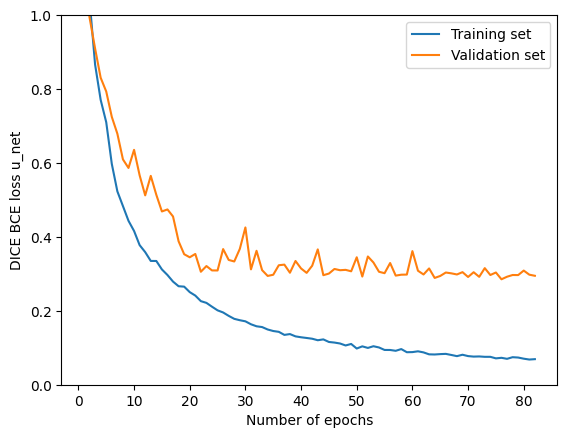

In [26]:
plt.plot(range(1, len(u_net_trainer.train_losses[0])+1), u_net_trainer.train_losses[0])
plt.plot(range(1, len(u_net_trainer.train_losses[0])+1), u_net_trainer.valid_losses[0])
plt.xlabel('Number of epochs')
plt.ylabel('DICE BCE loss u_net')
plt.ylim([0, 1])
plt.legend(['Training set', 'Validation set'])
plot_name = 'DICE_BCE_LOSS_'+ str(N_EPOCHS) + '_epochs_' + str(Number_of_fake) + "_number_of_fake.png"
path = EXPERIMENT_DIR / plot_name

plt.savefig(path, dpi=200)